Data shape: (2616, 20)
            timestamp  pm2_5   pm10   no2   so2      co     o3  nh3  aqi  \
0 2025-10-18 16:00:00  37.15  84.84  0.10  0.81  129.72  92.52  0.0    3   
1 2025-10-18 18:00:00  36.51  84.96  0.09  0.76  128.04  91.44  0.0    3   
2 2025-10-18 21:00:00  35.48  86.13  0.08  0.74  125.46  90.42  0.0    3   
3 2025-10-19 01:00:00  34.84  92.45  0.07  0.83  123.31  91.34  0.0    3   
4 2025-10-19 04:00:00  34.84  96.39  0.10  0.71  123.13  89.40  0.0    3   

   temperature  humidity  pressure  windspeed  winddirection  precipitation  \
0         33.7        23    1009.1       13.5            245            0.0   
1         30.0        52    1009.6        9.4            263            0.0   
2         26.6        78    1011.1        6.6            299            0.0   
3         24.1        92    1010.5        8.7            326            0.0   
4         24.2        86    1009.7        9.4            337            0.0   

   hour  day  month  day_of_week  aqi_change 

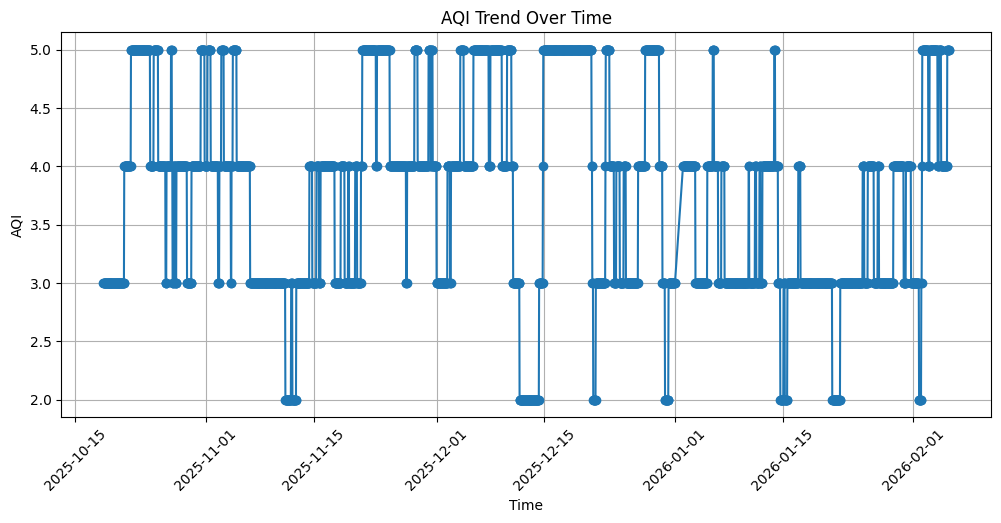


Performing seasonal decomposition on AQI...


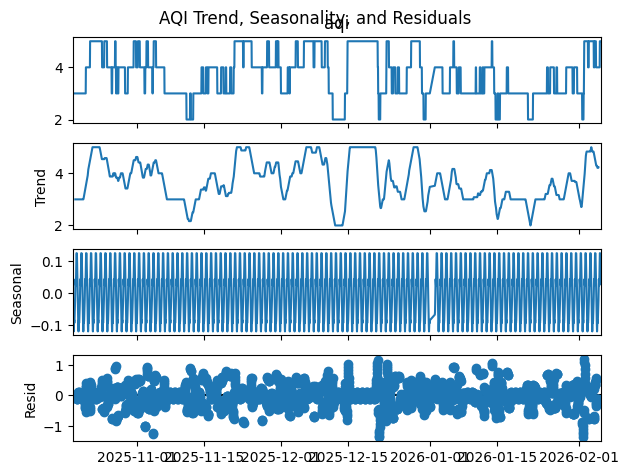

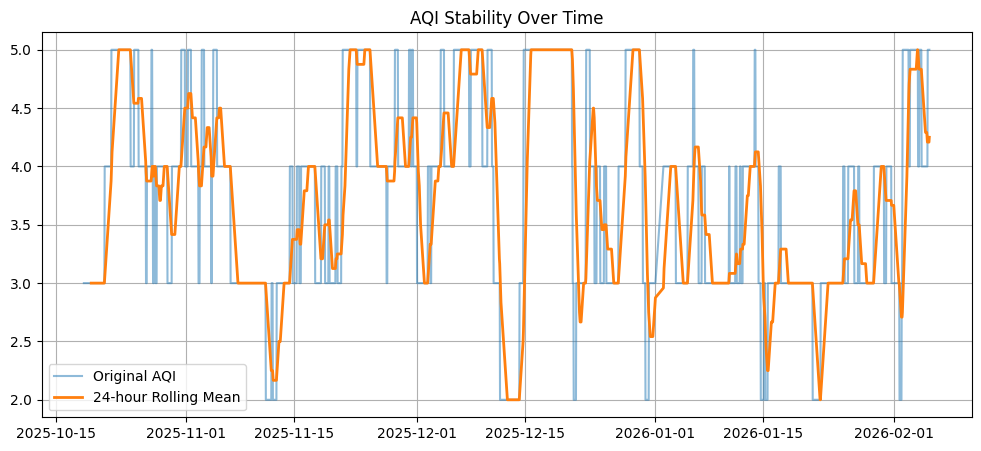

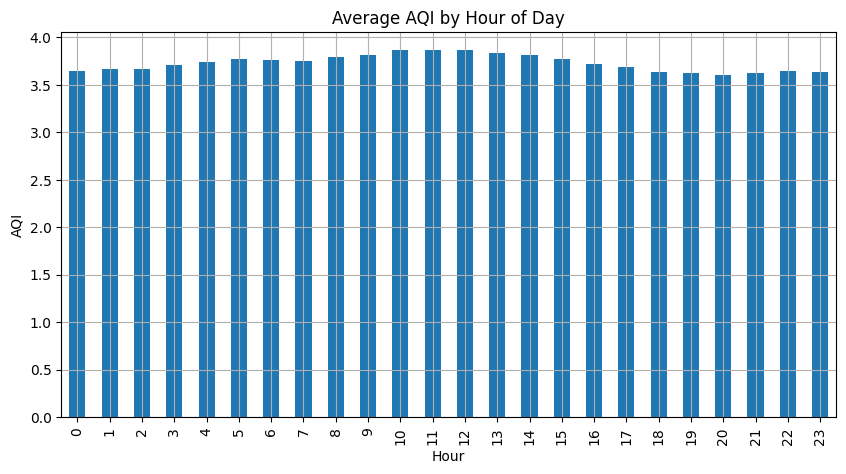

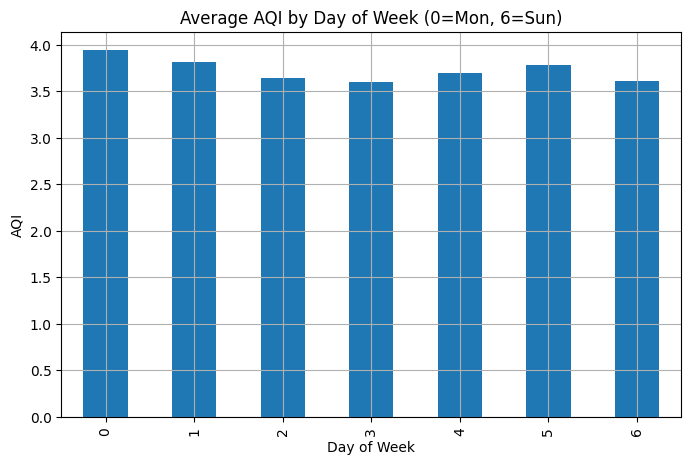

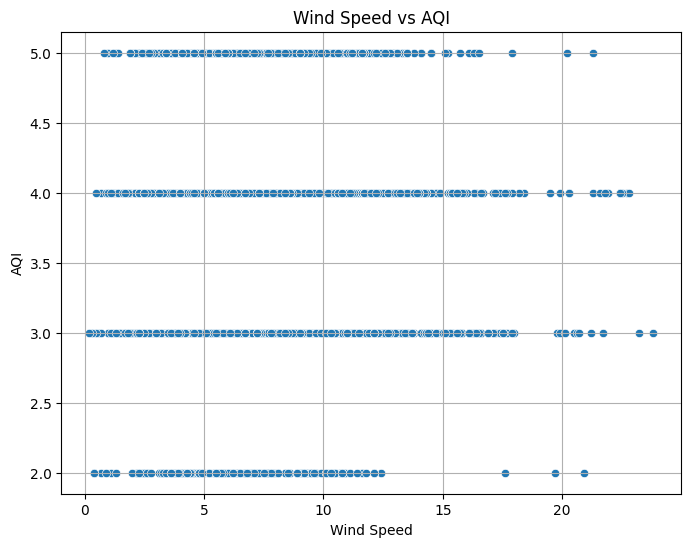

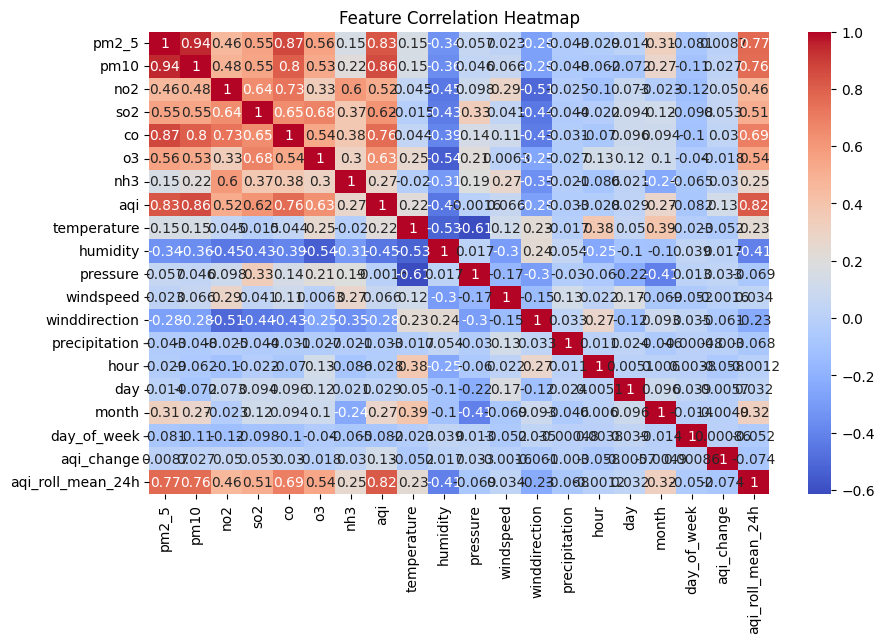

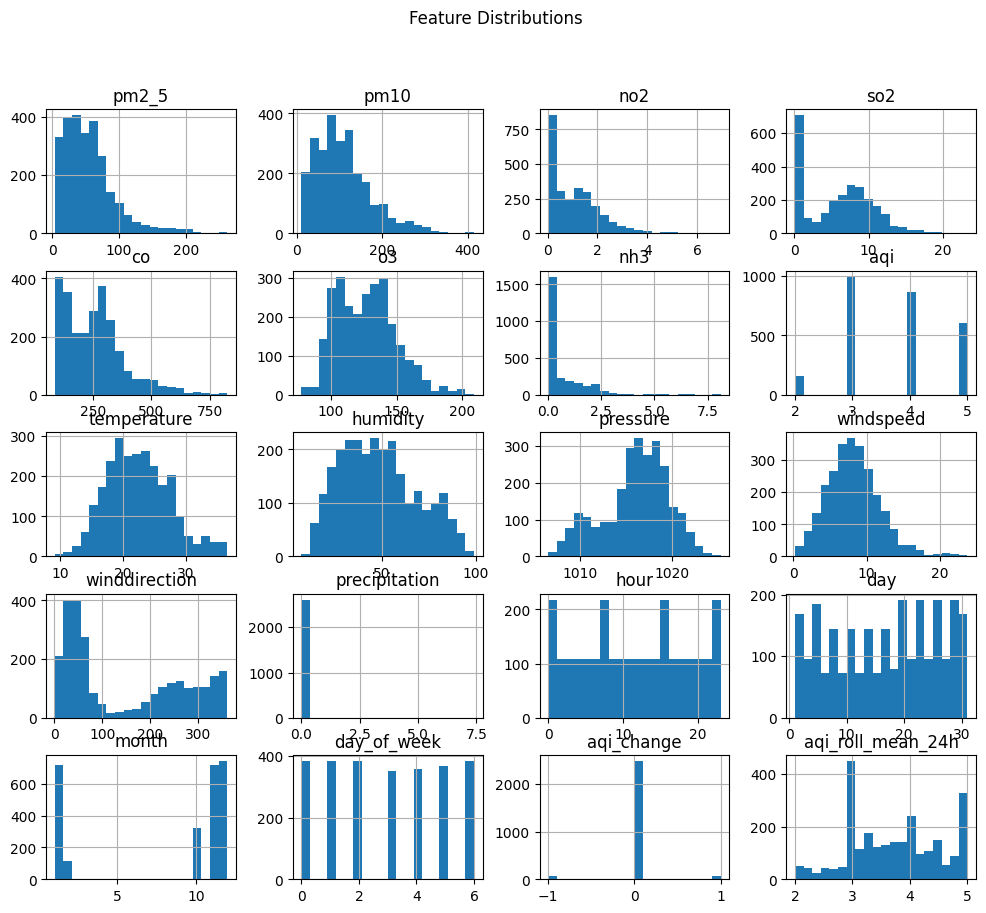

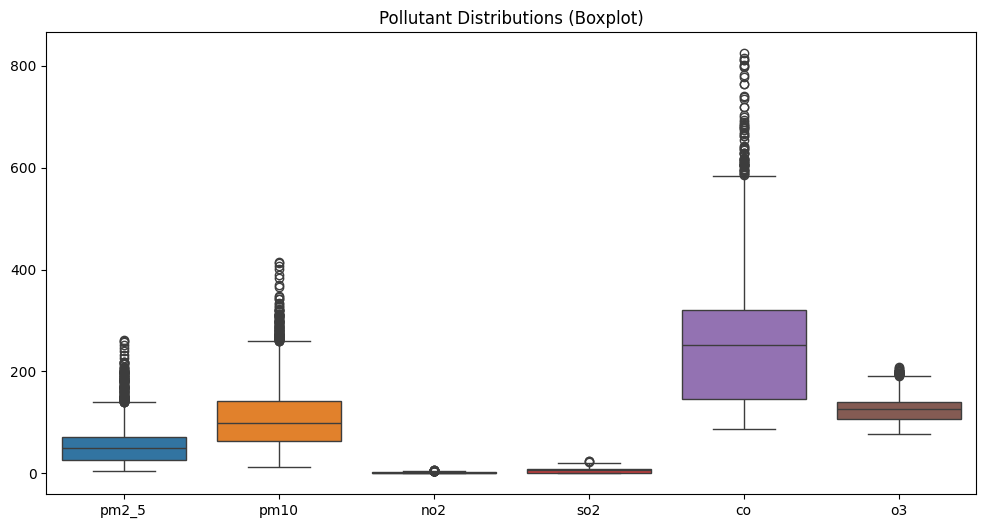

In [23]:
# 1️⃣ Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
from dotenv import load_dotenv
import os

# NEW FOR SEASONAL ANALYSIS
from statsmodels.tsa.seasonal import seasonal_decompose  

# 2️⃣ Load MongoDB connection
load_dotenv()
MONGO_URI = os.getenv("MONGO_URI")

client = MongoClient(MONGO_URI)
db = client["aqi_database"]
features_col = db["training_features"]   # <-- you are using "features" collection

# 3️⃣ Load data
df = pd.DataFrame(list(features_col.find()))
df = df.drop(columns=["_id"])  # drop Mongo internal ID

# 4️⃣ Quick look (UNCHANGED)
print("Data shape:", df.shape)
print(df.head())
print(df.describe())

# ---------------------------
# 5️⃣ Time-series trends (YOU HAD THIS — KEPT AS IS)
# ---------------------------
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp")   # <-- ADDED (important for time series)
df.set_index("timestamp", inplace=True)

plt.figure(figsize=(12, 5))
plt.plot(df.index, df["aqi"], marker='o', linestyle='-')
plt.title("AQI Trend Over Time")
plt.ylabel("AQI")
plt.xlabel("Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# =========================================================
# ✅ NEW: 6️⃣ TREND + SEASONALITY (MISSING BEFORE)
# =========================================================
# This was REQUIRED by the PDF but you did NOT have it before

print("\nPerforming seasonal decomposition on AQI...")

decomp = seasonal_decompose(df["aqi"], period=24, model="additive")  # 24 = hourly cycle

fig = decomp.plot()
plt.suptitle("AQI Trend, Seasonality, and Residuals", fontsize=12)
plt.show()

# =========================================================
# ✅ NEW: 7️⃣ ROLLING MEAN (STABILITY ANALYSIS)
# =========================================================
df["aqi_roll_mean_24h"] = df["aqi"].rolling(24).mean()

plt.figure(figsize=(12, 5))
plt.plot(df["aqi"], label="Original AQI", alpha=0.5)
plt.plot(df["aqi_roll_mean_24h"], label="24-hour Rolling Mean", linewidth=2)
plt.title("AQI Stability Over Time")
plt.legend()
plt.grid(True)
plt.show()

# =========================================================
# ✅ NEW: 8️⃣ HOURLY PATTERN (VERY IMPORTANT)
# =========================================================
hourly_avg = df.groupby(df.index.hour)["aqi"].mean()

plt.figure(figsize=(10, 5))
hourly_avg.plot(kind="bar")
plt.title("Average AQI by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("AQI")
plt.grid(True)
plt.show()

# =========================================================
# ✅ NEW: 9️⃣ WEEKDAY PATTERN (MON-SUN)
# =========================================================
df["day_of_week"] = df.index.dayofweek  # 0=Mon, 6=Sun
weekday_avg = df.groupby("day_of_week")["aqi"].mean()

plt.figure(figsize=(8, 5))
weekday_avg.plot(kind="bar")
plt.title("Average AQI by Day of Week (0=Mon, 6=Sun)")
plt.xlabel("Day of Week")
plt.ylabel("AQI")
plt.grid(True)
plt.show()

# =========================================================
# ✅ NEW: 🔟 WIND SPEED vs AQI (CAUSE ANALYSIS)
# =========================================================
if "windspeed" in df.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df["windspeed"], y=df["aqi"])
    plt.title("Wind Speed vs AQI")
    plt.xlabel("Wind Speed")
    plt.ylabel("AQI")
    plt.grid(True)
    plt.show()
else:
    print("⚠️ 'windspeed' column not found — skipping wind vs AQI plot")

# ---------------------------
# 11️⃣ Correlation heatmap (YOUR VERSION — KEPT)
# ---------------------------
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# ---------------------------
# 12️⃣ Histograms (YOUR VERSION — KEPT)
# ---------------------------
df.hist(figsize=(12, 10), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

# ---------------------------
# 13️⃣ Boxplots for pollutants (YOUR VERSION — KEPT)
# ---------------------------
pollutants = ["pm2_5","pm10","no2","so2","co","o3"]

# Only keep pollutants that actually exist in your data
pollutants = [p for p in pollutants if p in df.columns]

plt.figure(figsize=(12,6))
sns.boxplot(data=df[pollutants])
plt.title("Pollutant Distributions (Boxplot)")
plt.show()
